In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import pytz

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

file_dict = {'1a':['gold_subruns/gold_subruns_60Hr.txt', 'hdf5/2020-09-30_run_1a.h5', '/data2/aetb/2020-09-30_hybrid_maps.h5'],
             '1b':['gold_subruns/gold_subruns_HighKick.txt', 'hdf5/2020-09-30_run_1b.h5', '/data2/aetb/2020-09-30_hybrid_maps.h5'],
             '1c':['gold_subruns/gold_subruns_9day.txt', 'hdf5/2020-09-30_run_1c.h5', '/data2/aetb/2020-09-30_hybrid_maps.h5'],
             '1d':['gold_subruns/gold_subruns_endgame.txt', 'hdf5/2020-09-30_run_1d.h5', '/data2/aetb/2020-09-30_hybrid_maps.h5']}

key_dict = {'1a':{'1':['tr_df_1', 'tr_df_2', 'vtm_1']},
            '1b':{'1':['tr_df_1', 'tr_df_2', 'vtm_1'],
                  '2':['tr_df_2', 'tr_df_3', 'vtm_2']},
            '1c':{'1':['tr_df_1', 'tr_df_2', 'vtm_1'],
                  '2':['tr_df_3', 'tr_df_4', 'vtm_2'],
                  '3':['tr_df_4', 'tr_df_5', 'vtm_3'],
                  '4':['tr_df_5', 'tr_df_6', 'vtm_4']},
            '1d':{'2':['tr_df_2', 'tr_df_3', 'vtm_2'],
                  '3':['tr_df_4', 'tr_df_5', 'vtm_3'],
                  '4':['tr_df_6', 'tr_df_7', 'vtm_4'],
                  '5':['tr_df_7', 'tr_df_8', 'vtm_5'],
                  '6':['tr_df_8', 'tr_df_9', 'vtm_6']}}

rates = np.array([4.56668293e-03, 2.39702431e-04, 2.23624253e-04,
         1.06138686e-04, 3.40662192e-04, 3.02648014e-05,
         7.69850642e-05, 4.63122653e-05, 9.34178986e-05])/np.sqrt(72)  # 12 Oct 2020, `step_2_sync_offsets.ipynb`

Welcome to JupyROOT 6.22/02


In [20]:
run = '1d'
pair = '5'

filename = file_dict[run]
key = key_dict[run][pair]

gold_subruns = np.loadtxt(filename[0])

subrun_df = pd.read_hdf(filename[1], key='subrun_df')

# vtm_df = pd.read_hdf(filename[2], key='run_'+run+pair)

## calculate the (rough) times of trolley runs from interp dataframes
tr_interp_df_1 = pd.read_hdf(filename[1], key=key[0])
t_start = np.mean(tr_interp_df_1.index.values)

if (run == '1d') & (pair == '6'):
    t_end = 1530261096.0
else:
    tr_interp_df_2 = pd.read_hdf(filename[1], key=key[1])
    t_end = np.mean(tr_interp_df_2.index.values)

gold_subruns_df = pd.DataFrame(gold_subruns.astype(int), columns=['run', 'subrun']).merge(subrun_df, on=['run', 'subrun'])

gold_subruns_df = gold_subruns_df[(gold_subruns_df['start_gps']>=t_start) & (gold_subruns_df['end_gps']<=t_end)]

Uncertainty (Hz)

4.078179614275363	0.9343339703187119	0.9024546172424339	0.6217313593900677	1.1138530236757562	0.3319975157730743	0.5295038936383123	0.4106898144870134	0.5832852130824	

CPU times: user 3.68 s, sys: 3.99 s, total: 7.66 s
Wall time: 6.88 s


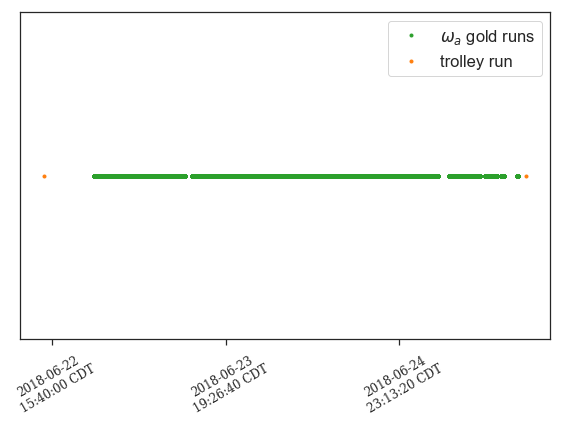

In [21]:
%%time

fig, ax = plt.subplots(1,1)

ax.plot(gold_subruns_df['start_gps'].values[0], [1], '.', color='C2', label=r'$\omega_a$ gold runs')
ax.plot(gold_subruns_df['start_gps'], np.ones(gold_subruns_df.shape), '.', color='C2')

# ax.plot(vtm_df.index.values, np.ones(vtm_df.shape[0]), color='C0', label='fixed probe data')
ax.plot([t_start, t_end], [1,1], '.', color='C1', label='trolley run')

ax.legend()
plt2.plt_unix_time_to_CST(ax)
ax.get_yaxis().set_visible(False)

fig.set_size_inches(8,6)
fig.tight_layout()

## a vector is number of ctags in each subrun divided by the number of ctags in all used subruns
a = gold_subruns_df['ctags'].values/float(gold_subruns_df['ctags'].sum())

## make vector of subrun times after trolley run (use avg)
t_subrun = ((gold_subruns_df['start_gps']+gold_subruns_df['end_gps'])/2).values - t_start
t_period = t_end - t_start


## build the covariance matrix sigma
## t1, t2 are the two times under consideration, can be matrices
def cov(t1, t2, T, M=0.01810259**2):  # units for M are Hz^2/sec
    u = np.minimum(t1, t2)
    v = np.maximum(t1, t2)
    return M * (T - v) * u / T

def cov2(t1, t2, T, M=0.01810259**2):  # units for M are Hz^2/sec
    u = np.minimum(t1, t2)
    v = np.maximum(t1, t2)
    return M * u

## make t1 a matrix of proper size with time by row; t2 is by column; ~10 sec
t1 = np.outer(t_subrun, np.ones(t_subrun.size))
t2 = np.outer(np.ones(t_subrun.size), t_subrun)

## run the cov function (note, this takes ~1 min)
# sigma = cov(t1, t2, t_period)

sigma = cov(t1, t2, t_period, M=1)  # use M=1, scale with rates later to save time
sigma_avg = np.dot(a, np.dot(sigma, a))
print 'Uncertainty (Hz)\n'
for m in range(9):
    ## this is the uncertainty of the average (variance) in Hz^2
    
    print str((sigma_avg*rates[m])**0.5)+'\t',
    
print '\n'


####


# print 'Period (hr)'
# print t_period/3600

# print 'RW uncertainty (ppb)'
# print 0.01810259*np.sqrt(t_period)*16/np.sqrt(3)
# print ''

# print 'BB uncertainty (ppb)'
# print 0.01810259*np.sqrt(t_period)*16/np.sqrt(12)
# print ''

# print 'Uncertainty (Hz)'
# print sigma_avg**0.5
# print '(ppb)'
# print sigma_avg**0.5*16